# ПРОЕКТИРОВАНИЕ СТВОЛА-МОНОБЛОКА

Прототип ЗиС-3 76-мм обр. 1942 г.

Унитарный тип заряжания.

In [1]:
# Импорт библиотек и модулей
from pyballistics import ozvb_termo as direct_task
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.lines

In [2]:
# настройка шрифтов
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Исходные данные:

In [3]:
d = 76.2e-3
q = 7.1
v_pm = 690
n_S = 1.04
p_0 = 30e6
p_ign = 5e6
g = 9.80665
ϕ1 = 1.02
S = n_S * np.pi * d**2 / 4
Wp = 0.015219895782310894 
l = Wp / (np.pi * d**2 / 4)

db = '16/1 тр'
ωq = 0.287
Δ = 530.9
ω = ωq * q
W_0 = ω / Δ

dt = 1e-6

t1 = 20
t2 = -50
t3 = 50

In [4]:
def fopts(t):
    T0 = 273.15 + t
    opts = {
     'powders': [{'omega': ω, 'dbname': db}],
     'init_conditions': {
     'q': q,
     'd': d,
     'W_0': W_0,
     'phi_1': ϕ1,
     'p_0': p_0,
     'n_S': n_S,
     'T_0': T0
     },
    'igniter': {'p_ign_0': p_ign},
    'meta_termo': {'dt': dt, 'method': 'rk4'},
    'stop_conditions': {'x_p': l}
     }
    return opts
opts1 = fopts(t1)
opts2 = fopts(t2)
opts3 = fopts(t3)

# Решение ОЗВБ:

In [5]:
solve1 = direct_task(opts1)
solve2 = direct_task(opts2)
solve3 = direct_task(opts3)

In [6]:
arr_t1 = solve1['t']
arr_pm1 = solve1['p_m']
arr_xp1 = solve1['x_p']
arr_Vp1 = solve1['v_p']
Vp1 = arr_Vp1[-1]
pm_max1 = arr_pm1.max()
pmd1 = arr_pm1[-1]
xp_pmax1 = arr_xp1[arr_pm1.argmax()]

arr_t_2 = solve2['t']
arr_pm2 = solve2['p_m']
arr_xp2 = solve2['x_p']
arr_Vp2 = solve2['v_p']
Vp_2 = arr_Vp2[-1]

arr_t_3 = solve3['t']
arr_pm3 = solve3['p_m']
arr_xp3 = solve3['x_p']
arr_Vp3 = solve3['v_p']
Vp_3 = arr_Vp3[-1]

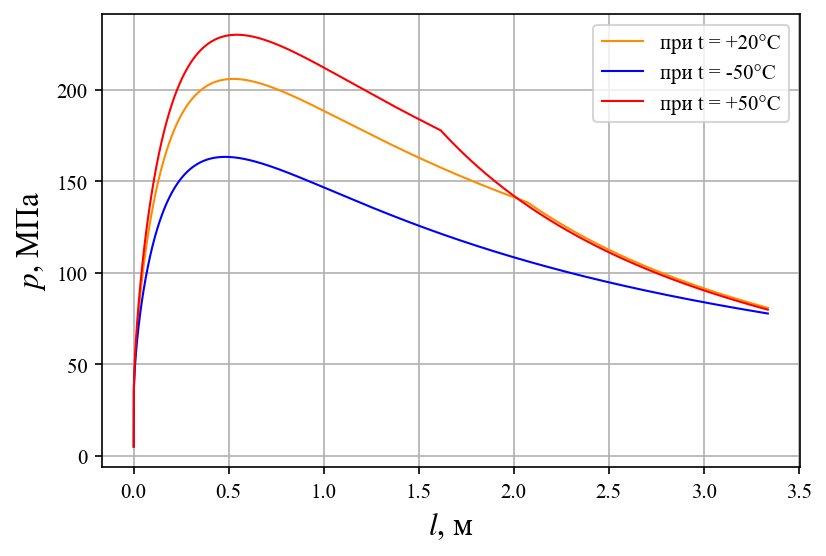

In [7]:
plt.figure(dpi = 150)
plt.plot(arr_xp1, arr_pm1 / 1e6, label='при t = +20°C', color = 'darkorange', linewidth = 1)
plt.plot(arr_xp2, arr_pm2 / 1e6, label='при t = -50°C', color = 'blue', linewidth = 1)
plt.plot(arr_xp3, arr_pm3 / 1e6, label='при t = +50°C', color = 'red', linewidth = 1)
plt.xlabel('$l$, м', fontsize = 15)
plt.ylabel('$p$, МПа', fontsize = 15)
plt.legend()
plt.grid()
plt.savefig('озвб.png', dpi=600, bbox_inches='tight')
plt.show()

In [8]:
K = (1 + 1/3 * ω/(1.02*q))**(-1)
pсн1, pсн2, pсн3 = arr_pm1/1e6 * K, arr_pm2/1e6 * K, arr_pm3/1e6 * K
pсн1_max, pсн2_max, pсн3_max = np.max(pсн1), np.max(pсн2), np.max(pсн3)

pсн_max = pсн3_max

lpсн_max = arr_xp3[arr_pm3.argmax()]
xm = lpсн_max + 1.5 * d

pкн_max = pсн_max * (1 + ω / (2*1.02*q)) 
pкн_max, pсн_max, lpсн_max

(239.9275902294643, 210.33617708126653, 0.5422210587498206)

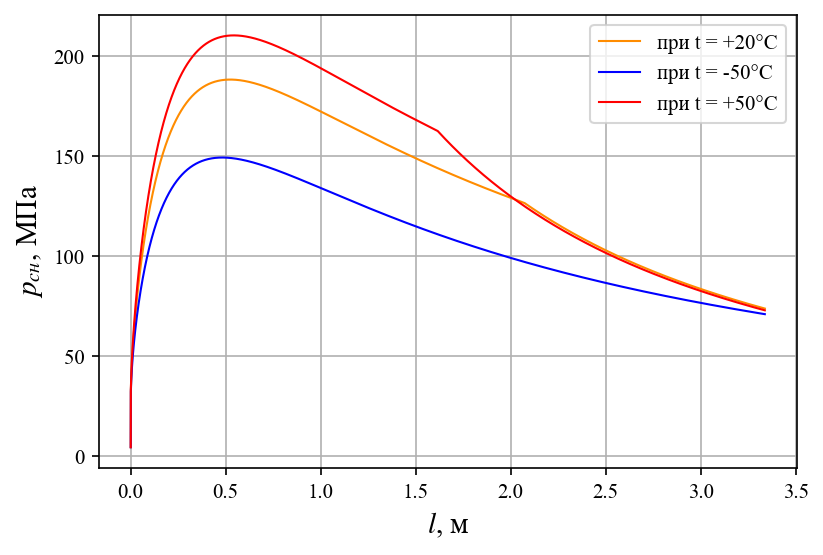

In [9]:
plt.figure(dpi = 150)
plt.plot(arr_xp1, pсн1, label='при t = +20°C', color = 'darkorange', linewidth = 1)
plt.plot(arr_xp2, pсн2, label='при t = -50°C', color = 'blue', linewidth = 1)
plt.plot(arr_xp3, pсн3, label='при t = +50°C', color = 'red', linewidth = 1)
plt.xlabel('$l$, м', fontsize = 14)
plt.ylabel('$p_{сн}$, МПа', fontsize = 14)
plt.legend()
plt.grid()
plt.savefig('озвб_давление_на_снаряд.png', dpi=600, bbox_inches='tight')
plt.show()

In [10]:
# длина каморы
l_ок = 0.768566
l_пк = 0.0381
l_ц = 0.06096
l_кв = 0.042863
l_kam = l_ок + l_пк + l_ц + l_кв
l_kam

0.910489

# Кривая огибающего давления:

In [11]:
# формируем массив координат камеры ствола от точки d до точки m
mass_l_dm = arr_xp2[arr_xp2 <= xm]
mass_dn = np.linspace(-l_kam, 0, 1000)
mass_l_dm = np.append(mass_dn, mass_l_dm)
dm = l_kam + xm

In [12]:
# построение огибающей давления на участке от d до m
Δp = pсн_max * (ω / (2 * ϕ1 * q))
mass_p_ogib_dm = -Δp * (((mass_l_dm + l_kam) ** 2) / (dm ** 2))
mass_p_ogib_dm = mass_p_ogib_dm + (pсн_max - mass_p_ogib_dm[-1]) # смещение параболы к точке m

In [13]:
#концы горения
mass_ψ1 = solve1['psi_1']
mass_ψ2 = solve2['psi_1']
mass_ψ3 = solve3['psi_1']

ind_η1 = len(mass_ψ1[mass_ψ1 < 1]) - 1
ind_η2 = len(mass_ψ2[mass_ψ2 < 1]) - 1
ind_η3 = len(mass_ψ3[mass_ψ3 < 1]) - 1

l_η1 = arr_xp1[ind_η1]
l_η2 = arr_xp2[ind_η2]
l_η3 = arr_xp3[ind_η3]

In [14]:
mass_l_ml = np.append(arr_xp3[(xm < arr_xp3) * (arr_xp3 < l_η1)], arr_xp1[(l_η1 < arr_xp1) * (arr_xp1 < l_η2)])
mass_l_ml = np.append(mass_l_ml, arr_xp2[arr_xp2 > l_η2])
mass_p_ogib_ml = np.zeros_like(mass_l_ml)

ind_pog1 = len(mass_l_ml[mass_l_ml <= l_η1])
ind_pog2 = len(mass_l_ml[mass_l_ml <= l_η2])
ind_pog3 = len(mass_l_ml[mass_l_ml <= l_η3])

mass_p_ogib_ml[ind_pog2:] = pсн2[arr_xp2 > l_η2]

# Дальше меняешь Δp1 и Δp3 (смотришь разницы между давлениями после сгорания порошка)
Δp12 = pсн1[arr_xp1 < l_η2][-1] - pсн2[ind_η2]
Δp31 = pсн1[ind_η1] - pсн3[arr_xp3 < l_η1][-1]

mass_p_ogib_ml[ind_pog1:ind_pog2] = pсн1[(l_η1 < arr_xp1) * (arr_xp1 < l_η2)] # + Δp12
mass_p_ogib_ml[:ind_pog1] = pсн3[(xm < arr_xp3) * (arr_xp3 < l_η1)] + Δp31

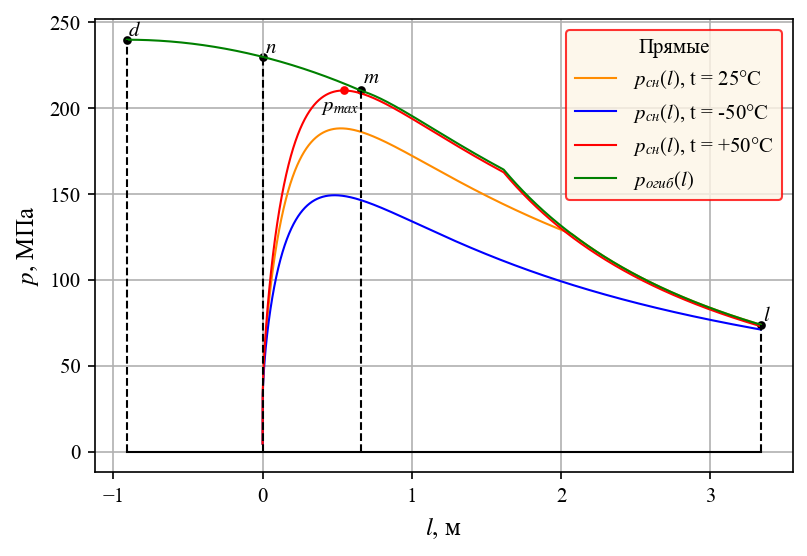

In [15]:
plt.figure(dpi = 150)
ax = plt.axes()

plt.scatter(lpсн_max, pсн3_max, color = 'red', s = 10)
plt.scatter(mass_l_dm[0], mass_p_ogib_dm.max(), color = 'black', s = 10)
plt.scatter(0, mass_p_ogib_dm[mass_l_dm < 0][-1], color = 'black', s = 10)
plt.scatter(mass_l_ml[-1], mass_p_ogib_ml[-1], color = 'black', s = 10)

line = matplotlib.lines.Line2D ([xm, xm], [0, pсн3_max], linewidth = 1, linestyle = 'dashed', color="black")
line1 = matplotlib.lines.Line2D ([0, 0], [0, mass_p_ogib_dm[mass_l_dm < 0][-1]], linewidth = 1, linestyle = 'dashed', color="black")
line2 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [0, mass_p_ogib_dm.max()], linewidth = 1, linestyle = 'dashed', color="black")
line3 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_ml[-1]], [0, 0], linewidth = 1, linestyle = 'solid', color="black")
line4 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [0, mass_p_ogib_ml[-1]], linewidth = 1, linestyle = 'dashed', color="black")

plt.plot(arr_xp1, pсн1, label='$p_{сн}(l)$, t = 25°C',  color = 'darkorange', linewidth = 1)
plt.plot(arr_xp2, pсн2, label='$p_{сн}(l)$, t = -50°C', color = 'blue',  linewidth = 1)
plt.plot(arr_xp3, pсн3, label='$p_{сн}(l)$, t = +50°C', color = 'red',   linewidth = 1)

plt.plot(mass_l_dm, mass_p_ogib_dm, label='$p_{огиб}(l)$', color = 'green', linewidth = 1)
plt.plot(mass_l_ml, mass_p_ogib_ml, color = 'green', linewidth = 1)

plt.scatter(xm, pсн_max, color = 'black', s = 10)

plt.text(mass_l_dm[0] + d/10, 1.01 * mass_p_ogib_dm.max(), '$d$', fontsize=10, color='black')
plt.text(d/5, 1.01 * mass_p_ogib_dm[mass_l_dm < 0][-1], '$n$', fontsize=10, color='black')
plt.text(xm + d/5, 1.02 * pсн3_max, '$m$', fontsize=10, color='black')
plt.text(mass_l_ml[-1] + d/5, 1.03 * mass_p_ogib_ml[-1], '$l$', fontsize=10, color='black')
plt.text(lpсн_max - 2*d, pсн3_max - 12, '$p_{max}$', fontsize=10, color='black')

ax.add_line(line)
ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)
ax.add_line(line4)

plt.legend(
    fontsize = 10,
    ncol = 1,
    facecolor = 'oldlace',
    loc='upper right',
    edgecolor = 'r',
    title = 'Прямые',
    title_fontsize = '10')

plt.xlabel('$l$, м', fontsize = 12)
plt.ylabel('$p$, МПа', fontsize = 12)

plt.grid()

plt.savefig('огибающая_кривая_давления.png', dpi=600, bbox_inches='tight')

plt.show()

# Кривая желаемого давления:

In [16]:
mass_l = np.append(mass_l_dm, mass_l_ml)
mass_p_ogib = np.append(mass_p_ogib_dm, mass_p_ogib_ml)

In [17]:
mass_n = np.zeros_like(mass_l)
mass_n[mass_l < 0] = 1
mass_n[(0 <= mass_l) * (mass_l < xm)] = 1.2
ml = mass_l[-1] - xm
mass_n[xm < mass_l] = 1.2 + 0.7 * ((mass_l[xm < mass_l] - xm) / ml)
mass_p_ж = mass_p_ogib * mass_n

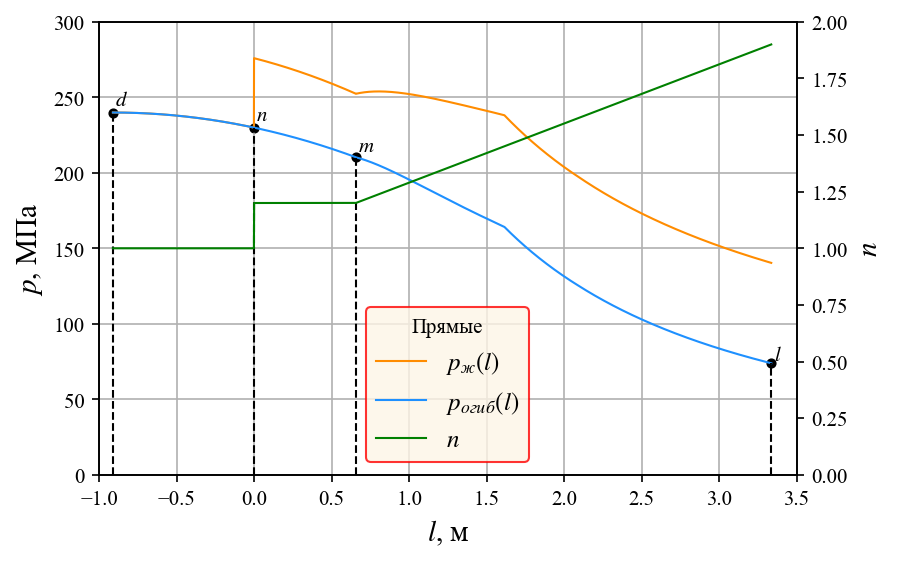

In [18]:
fig = plt.figure(dpi = 150)

host = fig.add_subplot(111)
par1 = host.twinx()

host.set_xlim(-1, 3.5)

plim = (0, 300)
nlim = (0, 2)

host.set_ylim(*plim)
par1.set_ylim(*nlim)

host.set_xlabel("$l$, м", fontsize = 14)
host.set_ylabel("$p$, МПа", fontsize = 14)
par1.set_ylabel("$n$", fontsize = 14)

p1, = host.plot(mass_l, mass_p_ж, color='darkorange', label='$p_{ж}(l)$', linewidth=1)
p11, = host.plot(mass_l, mass_p_ogib, color='dodgerblue', label='$p_{огиб}(l)$', linestyle = 'solid', linewidth=1)
p2, = par1.plot(mass_l, mass_n, color='green', label='$n$', linestyle = 'solid', linewidth=1)

lns = [p1, p11, p2]

host.legend(handles=lns,
            fontsize = 12,
            ncol = 1,
            facecolor = 'oldlace',
            loc='lower center',
            edgecolor = 'r',
            title = 'Прямые',
            title_fontsize = '10')

host.scatter(mass_l_dm[0], mass_p_ogib_dm.max(), color = 'black', s = 15)
host.scatter(0, mass_p_ogib_dm[mass_l_dm < 0][-1], color = 'black', s = 15)
host.scatter(mass_l_ml[-1], mass_p_ogib_ml[-1], color = 'black', s = 15)
host.scatter(xm, mass_p_ogib_dm[mass_l_dm < xm][-1], color = 'black', s = 15)

host.text(mass_l_dm[0] + d/5, 1.02 * mass_p_ogib_dm.max(), '$d$', fontsize=10, color='black')
host.text(d/5, 1.02 * mass_p_ogib_dm[mass_l_dm < 0][-1], '$n$', fontsize=10, color='black')
host.text(xm + d/5, 1.02 * pсн3_max, '$m$', fontsize=10, color='black')
host.text(mass_l_ml[-1] + d/5, 1.03 * mass_p_ogib_ml[-1], '$l$', fontsize=10, color='black')

line = matplotlib.lines.Line2D ([xm, xm], [0, pсн_max], linewidth = 1, linestyle = 'dashed', color="black")
line1 = matplotlib.lines.Line2D ([0, 0], [0, mass_p_ogib_dm[mass_l_dm < 0][-1]], linewidth = 1, linestyle = 'dashed', color="black")
line2 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [0, mass_p_ogib_dm.max()], linewidth = 1, linestyle = 'dashed', color="black")
line4 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [0, mass_p_ogib_ml[-1]], linewidth = 1, linestyle = 'dashed', color="black")

host.add_line(line)
host.add_line(line1)
host.add_line(line2)
host.add_line(line4)

host.grid()

plt.savefig('желаемая_кривая_давления.png', dpi=600, bbox_inches='tight')

plt.show()

# Геометрия каморы:

In [19]:
t = 0.0009525 # глубина нарезов, м
d1 = 0.079    # конус врезания, м
dц = 0.079    # цилиндрический участок, м
d2 = 0.0798   # переходный конус, м
d3 = 0.0874   # основной конус, м

In [20]:
# массив диаметров каморы в каждом сечении
mass_d_kamora = np.zeros_like(mass_l[mass_l <= 0])
# массив координат каморы (от нуля до дна каморы с "+" знаком)
mass_l_kamora = mass_l[mass_l <= 0] - mass_l[mass_l <= 0][0]
# Считается изменение диаметра каморы по сечениям
mass_d_kamora[mass_l_kamora <= l_ок] = d3 - (d3 - d2) * (mass_l_kamora[mass_l_kamora <= l_ок] / l_ок)
mass_d_kamora[(l_ок < mass_l_kamora) * (mass_l_kamora < l_ок + l_пк)] = d2 - (d2 - d1) * ((mass_l_kamora[(l_ок < mass_l_kamora) * (mass_l_kamora < l_ок + l_пк)] - l_ок) / l_пк)
mass_d_kamora[(l_ок + l_пк < mass_l_kamora) * (mass_l_kamora < l_ок + l_пк + l_ц)] = dц
mass_d_kamora[l_ок + l_пк + l_ц < mass_l_kamora] = d1 - (d1 - d) * ((mass_l_kamora[l_ок + l_пк + l_ц < mass_l_kamora] - (l_ок + l_пк + l_ц)) / l_кв)

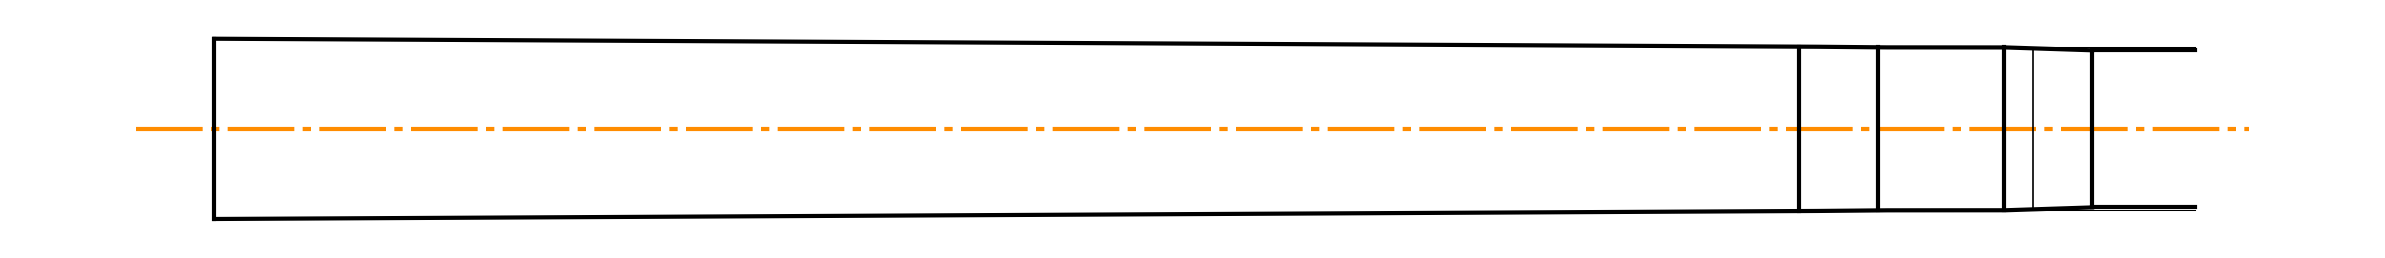

In [21]:
fs = (10, 2)
dpi = 300
fig, ax=plt.subplots(figsize=fs, dpi=dpi)
ax.set_aspect('equal')

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

plt.plot(mass_l_kamora, mass_d_kamora / 2, linewidth = 1, color = 'black')
plt.plot(mass_l_kamora, -mass_d_kamora / 2, linewidth = 1, color = 'black')

# ось
line_os = matplotlib.lines.Line2D ([mass_l_kamora[0] - d/2, mass_l_kamora[-1] + d], [0, 0], linewidth = 1, dashes=[16,2,2,2], color="darkorange")
# дно каморы
line1 = matplotlib.lines.Line2D ([0, 0], [-d3/2, d3/2], linewidth = 1, linestyle = 'solid', color="black")
# линия пересечения основного конуса с переходным конусом
line2 = matplotlib.lines.Line2D ([l_ок, l_ок], [-d2/2, d2/2], linewidth = 1, linestyle = 'solid', color="black")
# линия пересечения переходного конуса с  цилиндрическим участком
line3 = matplotlib.lines.Line2D ([l_ок + l_пк, l_ок + l_пк], [-d1/2, d1/2], linewidth = 1, linestyle = 'solid', color="black")
# линия пересечения цилиндрического участка с конусом врезания
line4 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц, l_ок + l_пк + l_ц], [-d1/2, d1/2], linewidth = 1, linestyle = 'solid', color="black")
# линия пересечения с канала с нарезами с конусом врезания
line5 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв, l_ок + l_пк + l_ц + l_кв ], [-d/2, d/2], linewidth = 1, linestyle = 'solid', color="black")
# линия нарезов сверху
line6 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв / 3, mass_l_kamora[-1] + 0.05], [d/2 + 1.5*t, d/2 + 1.5*t], linewidth = 0.25, linestyle = 'solid', color="black")
# линия нарезов снизу
line6n = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв / 3, mass_l_kamora[-1] + 0.05], [-d/2 - 1.5*t, -d/2 - 1.5*t], linewidth = 0.25, linestyle = 'solid', color="black")
# линия калибра сверху
line7 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв, mass_l_kamora[-1] + 0.05], [d/2 , d/2], linewidth = 1, linestyle = 'solid', color="black")
# линия калибра снизу
line7n = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв, mass_l_kamora[-1] + 0.05], [-d/2 , -d/2], linewidth = 1, linestyle = 'solid', color="black")
# линия начала нарезов в конусе врезания
line8 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв / 3, l_ок + l_пк + l_ц + l_кв / 3], [-d/2 - t, d/2 + t], linewidth = 0.4, linestyle = 'solid', color="black")

ax.add_line(line_os)
ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)
ax.add_line(line4)
ax.add_line(line5)
ax.add_line(line6)
ax.add_line(line7)
ax.add_line(line6n)
ax.add_line(line7n)
ax.add_line(line8)

plt.savefig('внутренняя геометрия ствола.png', dpi=600, bbox_inches='tight')

In [22]:
# Расчёт наружных радиусов ствола из второй теории прочности
mass_d_kamora[mass_d_kamora < d + 2 * t] = d + 2 * t
mass_r1 = np.zeros_like(mass_l)
mass_r1[mass_l <= 0] = mass_d_kamora / 2
mass_r1[mass_l > 0] = d / 2 + t
σe = 700
mass_r2 = mass_r1 * np.sqrt((3 * σe + 2 * mass_p_ж) / (3 * σe - 4 * mass_p_ж))
Δr = mass_r2 - mass_r1

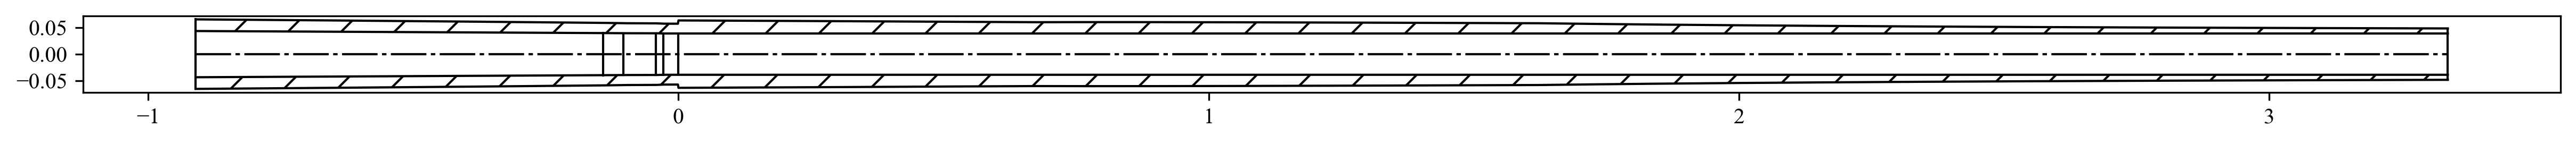

In [23]:
fig = plt.figure(figsize = (20, 5), dpi = 300)
ax = plt.axes()

ax.set_aspect('equal')

linewidth1 = 1

plt.plot(mass_l, mass_r2, color = 'black', linewidth = linewidth1)
plt.plot(mass_l, mass_r1, color = 'black', linewidth = linewidth1)

plt.plot(mass_l, -mass_r2, color = 'black', linewidth = linewidth1)
plt.plot(mass_l, -mass_r1, color = 'black', linewidth = linewidth1)

line1 = matplotlib.lines.Line2D ([mass_l[0], mass_l[0]], [-mass_r2[0], mass_r2[0]], linewidth = linewidth1, linestyle = 'solid', color="black")
line2 = matplotlib.lines.Line2D ([l_ок + mass_l[0], l_ок + mass_l[0]], [-d2/2, d2/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line3 = matplotlib.lines.Line2D ([l_ок + l_пк + mass_l[0], l_ок + l_пк + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line4 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + mass_l[0], l_ок + l_пк + l_ц + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line5 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв + mass_l[0], l_ок + l_пк + l_ц + l_кв + mass_l[0]], [-d/2, d/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line6 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв / 3 + mass_l[0], l_ок + l_пк + l_ц + l_кв / 3 + mass_l[0]], [-d/2 - t, d/2 + t], linewidth = linewidth1, linestyle = 'solid', color="black")
line7 = matplotlib.lines.Line2D ([mass_l[-1], mass_l[-1]], [-mass_r2[-1], mass_r2[-1]], linewidth = linewidth1, linestyle = 'solid', color="black")

ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)
ax.add_line(line4)
ax.add_line(line5)
ax.add_line(line6)
ax.add_line(line7)

plt.fill_between(mass_l, mass_r2, mass_r1, facecolor="none", hatch="/", edgecolor="black", linewidth=0.1)
plt.fill_between(mass_l, -mass_r2, -mass_r1, facecolor="none", hatch="/", edgecolor="black", linewidth=0.1)

line_os = matplotlib.lines.Line2D ([mass_l[0], mass_l[-1]], [0, 0], linewidth = 1, dashes=[16,2,2,2], color="black")

ax.add_line(line_os)

plt.savefig('геометрия ствола полная.png', dpi=600, bbox_inches='tight')

# Конструкторская проработка:

In [24]:
Λ = 0.82 # длина отката
Δl = 0.1
L_lulka = Λ + Δl
d_lulka = 2 * round(mass_r2.max(), 3)
L_fl = 0.5 * d
d_fl = d_lulka + 0.5 * d
L_mufta = 1.5 * d
Lconstr = L_lulka + L_fl + L_mufta
Lconstr, d_lulka, d_fl, L_fl, L_mufta, L_lulka

(1.0724, 0.132, 0.1701, 0.0381, 0.11430000000000001, 0.9199999999999999)

In [25]:
mass_r2_constr = np.zeros_like(mass_r2)
mass_r2_constr[mass_l <= mass_l[0] + L_fl] = d_fl / 2
mass_r2_constr[(mass_l[0] + L_fl < mass_l) * (mass_l <= mass_l[0] + Lconstr)] = d_lulka / 2
r2_η3 = mass_r2[mass_l < l_η3][-1]
mass_r2_constr[(mass_l[0] + Lconstr < mass_l) * (mass_l <= l_η3)] = d_lulka/2 - (d_lulka/2 - r2_η3) * ((mass_l[(mass_l[0] + Lconstr < mass_l) * (mass_l <= l_η3)] - (mass_l[0] + Lconstr)) / (l_η3 - (mass_l[0] + Lconstr)))
mass_r2_constr[(l_η3 < mass_l) * (mass_l <= mass_l[-1] - d)] = mass_r2[(l_η3 < mass_l) * (mass_l <= mass_l[-1] - d)]
mass_r2_constr[mass_l[-1] - 1.5 * d < mass_l] = mass_r2[-1] + 0.005

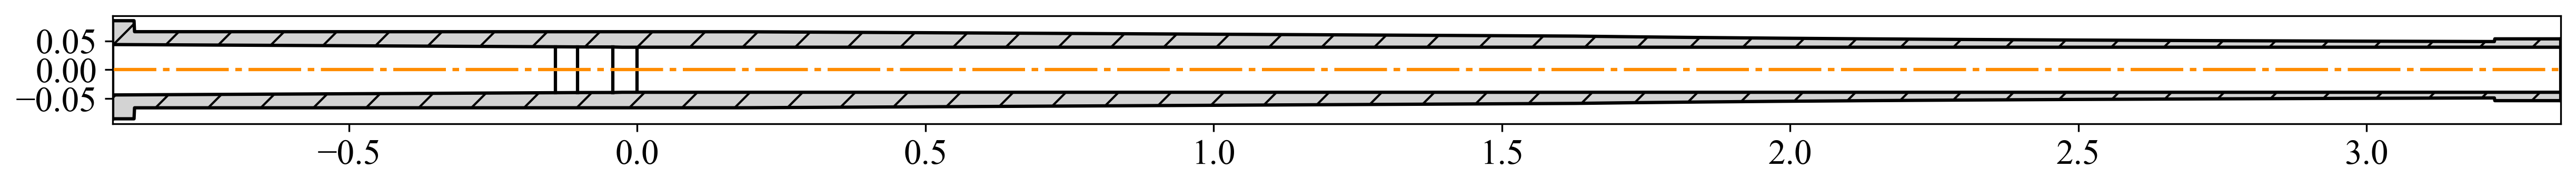

In [26]:
fig = plt.figure(figsize = (20, 5), dpi = 300)

ax = plt.axes()
ax.set_aspect('equal')

linewidth1 = 1.5
linewidth2 = 0.1

plt.plot(mass_l, mass_r2_constr, color="black", linewidth = linewidth1)
plt.plot(mass_l, mass_r1, color="black", linewidth = linewidth1)

plt.plot(mass_l, -mass_r2_constr, color="black", linewidth = linewidth1)
plt.plot(mass_l, -mass_r1, color="black", linewidth = linewidth1)

line_os = matplotlib.lines.Line2D ([mass_l[0] - d/5, mass_l[-1] + d/5], [0, 0], linewidth = linewidth1, dashes=[16,2,2,2], color="darkorange")

line1 = matplotlib.lines.Line2D ([mass_l[0], mass_l[0]], [-mass_r2_constr[0], mass_r2_constr[0]], linewidth = linewidth1, linestyle = 'solid', color="black")
line2 = matplotlib.lines.Line2D ([l_ок + mass_l[0], l_ок + mass_l[0]], [-d2/2, d2/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line3 = matplotlib.lines.Line2D ([l_ок + l_пк + mass_l[0], l_ок + l_пк + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line4 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + mass_l[0], l_ок + l_пк + l_ц + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line5 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв + mass_l[0], l_ок + l_пк + l_ц + l_кв + mass_l[0]], [-d/2, d/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line6 = matplotlib.lines.Line2D ([mass_l[-1], mass_l[-1]], [-mass_r2_constr[-1], mass_r2_constr[-1]], linewidth = linewidth1, linestyle = 'solid', color="black")

ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)
ax.add_line(line4)
ax.add_line(line5)
ax.add_line(line6)

plt.fill_between(mass_l,  mass_r2_constr,  mass_r1, facecolor="lightgrey", step ='mid', hatch="/", edgecolor="black", linewidth=linewidth2)
plt.fill_between(mass_l, -mass_r2_constr, -mass_r1, facecolor="lightgrey", hatch="/", edgecolor="black", linewidth=linewidth2)

ax.tick_params(labelsize=16)
ax.add_line(line_os)
plt.xlim(mass_l[0], mass_l[-1])

plt.savefig('геометрия ствола полная 2.png', dpi=600, bbox_inches='tight')

# Прочностной расчет:

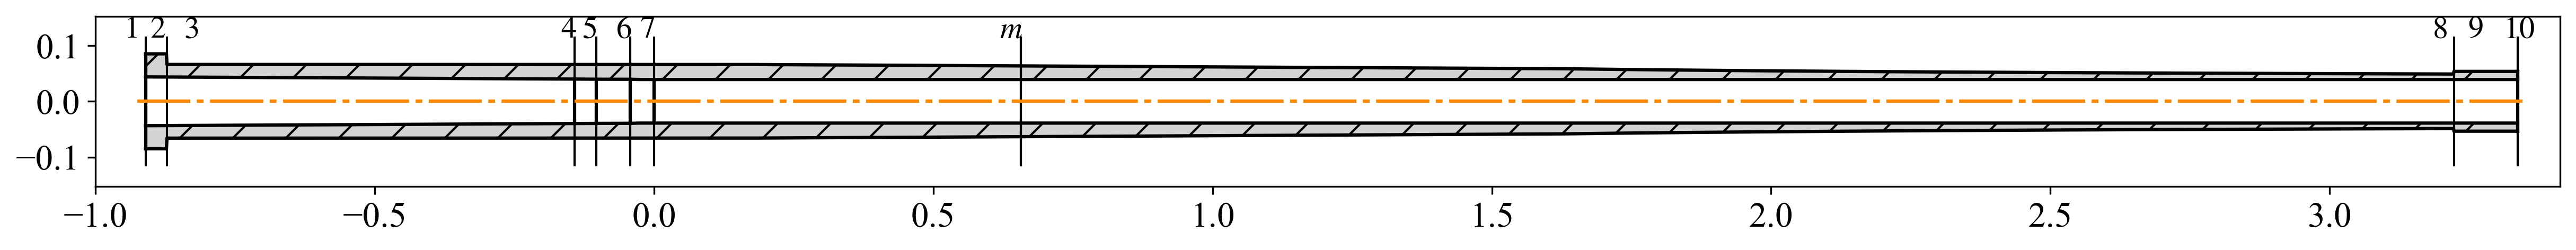

In [27]:
# ВЫБОР ОПАСНЫХ СЕЧЕНИЙ
fig = plt.figure(figsize = (20, 5), dpi = 300)

ax = plt.axes()
ax.set_aspect('equal')

linewidth1 = 1.5
linewidth_graf2 = 1

plt.plot(mass_l, mass_r2_constr, color="black", linewidth = linewidth1)
plt.plot(mass_l, mass_r1, color="black", linewidth = linewidth1)

plt.plot(mass_l, -mass_r2_constr, color="black", linewidth = linewidth1)
plt.plot(mass_l, -mass_r1, color="black", linewidth = linewidth1)

line_os = matplotlib.lines.Line2D ([mass_l[0] - d/5, mass_l[-1] + d/5], [0, 0], linewidth = linewidth1, dashes=[16,2,2,2], color="darkorange")

line1 = matplotlib.lines.Line2D ([mass_l[0], mass_l[0]], [-mass_r2_constr[0], mass_r2_constr[0]], linewidth = linewidth1, linestyle = 'solid', color="black")
line2 = matplotlib.lines.Line2D ([l_ок + mass_l[0], l_ок + mass_l[0]], [-d2/2, d2/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line3 = matplotlib.lines.Line2D ([l_ок + l_пк + mass_l[0], l_ок + l_пк + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line4 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + mass_l[0], l_ок + l_пк + l_ц + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line5 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв + mass_l[0], l_ок + l_пк + l_ц + l_кв + mass_l[0]], [-d/2, d/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line6 = matplotlib.lines.Line2D ([mass_l[-1], mass_l[-1]], [-mass_r2_constr[-1], mass_r2_constr[-1]], linewidth = linewidth1, linestyle = 'solid', color="black")

linek00 = matplotlib.lines.Line2D ([xm, xm], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek11 = matplotlib.lines.Line2D ([mass_l_dm[0] + L_fl, mass_l_dm[0] + L_fl], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek22 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок, mass_l_dm[0] + l_ок], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek33 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок + l_пк, mass_l_dm[0] + l_ок + l_пк], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek44 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок + l_пк + l_ц, mass_l_dm[0] + l_ок + l_пк + l_ц], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek55 = matplotlib.lines.Line2D ([0, 0], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek66 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek77 = matplotlib.lines.Line2D ([mass_l[-1] - 1.5*d, mass_l[-1] - 1.5*d], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linek88 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")
linekmm = matplotlib.lines.Line2D ([xm, xm], [-1.5*d, 1.5*d], linewidth = linewidth_graf2, linestyle = 'solid', color="black")


ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)
ax.add_line(line4)
ax.add_line(line5)
ax.add_line(line6)

ax.add_line(line_os)
ax.add_line(linek00)
ax.add_line(linek11)
ax.add_line(linek22)
ax.add_line(linek33)
ax.add_line(linek44)
ax.add_line(linek55)
ax.add_line(linek66)
ax.add_line(linek77)
ax.add_line(linek88)
ax.add_line(linekmm)

plt.text(mass_l[0] - d/2, 1.5 * d, '$1$', fontsize=14, color='black')
plt.text(mass_l[0] + L_fl - d/2.5, 1.5 * d, '$2$', fontsize=14, color='black')
plt.text(mass_l[0] + L_fl + d/2.5, 1.5 * d, '$3$', fontsize=14, color='black')
plt.text(mass_l[0] + l_ок - d/3, 1.5 * d, '$4$', fontsize=14, color='black')
plt.text(mass_l[0] + l_ок + l_пк - d/3, 1.5 * d, '$5$', fontsize=14, color='black')
plt.text(mass_l[0] + l_ок + l_пк + l_ц - d/3, 1.5 * d, '$6$', fontsize=14, color='black')
plt.text(0 - d/3, 1.5 * d, '$7$', fontsize=14, color='black')
plt.text(mass_l[-1] - 1.5*d - d/2, 1.5 * d, '$8$', fontsize=14, color='black')
plt.text(mass_l[-1] - 1.5*d + d/3, 1.5 * d, '$9$', fontsize=14, color='black')
plt.text(mass_l[-1] - d/3, 1.5 * d, '$10$', fontsize=14, color='black')
plt.text(xm - d/2, 1.5 * d, '$m$', fontsize=14, color='black')

plt.fill_between(mass_l,  mass_r2_constr,  mass_r1, facecolor="lightgrey", step ='mid', hatch="/", edgecolor="black", linewidth=linewidth2)
plt.fill_between(mass_l, -mass_r2_constr, -mass_r1, facecolor="lightgrey", hatch="/", edgecolor="black", linewidth=linewidth2)

plt.xlim(-1, mass_l[-1] + d)
plt.ylim(-2*d, 2*d)

ax.tick_params(labelsize=16)
ax.add_line(line_os)

plt.savefig('выбор_опасных_сечений.png', dpi=600, bbox_inches='tight')

In [28]:
mass_p1d = 1.5 * σe * (((mass_r2_constr / mass_r1) ** 2 - 1) / (2 * ((mass_r2_constr / mass_r1) ** 2) + 1))
mass_nd = mass_p1d / mass_p_ogib

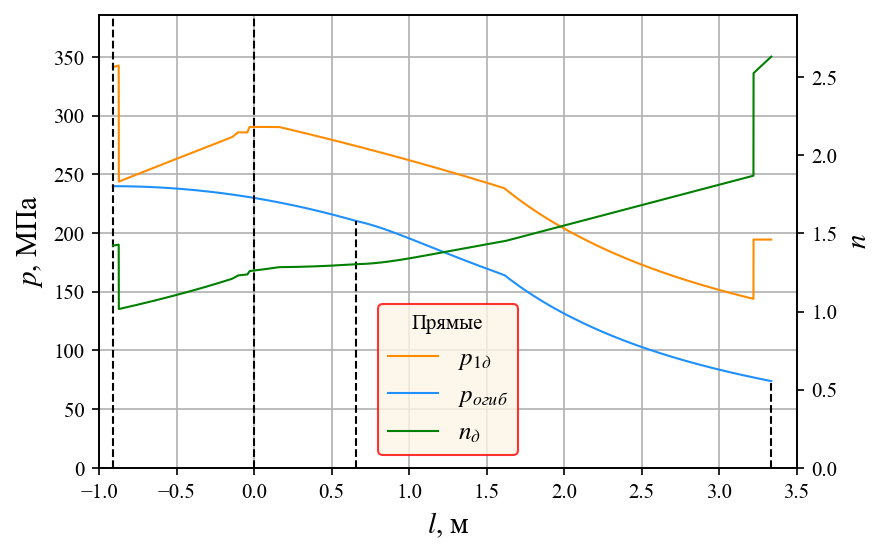

In [29]:
fig = plt.figure(dpi = 150)
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlim(-1, 3.5)

plim = (0, mass_p_ж.max() + 110)
nlim = (0, mass_n.max() + 1)

host.set_ylim(*plim)
par1.set_ylim(*nlim)

host.set_xlabel("$l$, м", fontsize = 14)
host.set_ylabel("$p$, МПа", fontsize = 14)
par1.set_ylabel("$n$", fontsize = 14)

p1, = host.plot(mass_l, mass_p1d, label='$p_{1д}$', color = 'darkorange', linewidth = 1)
p11, = host.plot(mass_l, mass_p_ogib, color='dodgerblue', label='$p_{огиб}$', linewidth = 1, linestyle = 'solid')
p2, = par1.plot(mass_l, mass_nd, color='green', label='$n_{д}$', linestyle = 'solid', linewidth = 1)

lns = [p1, p11, p2]

host.legend(handles=lns,
            fontsize = 12,
            ncol = 1,
            facecolor = 'oldlace',
            loc='lower center',
            edgecolor = 'r',
            title = 'Прямые',
            title_fontsize = '10')

line = matplotlib.lines.Line2D ([xm, xm], [0, pсн_max], linewidth = 1, linestyle = 'dashed', color="black")
line1 = matplotlib.lines.Line2D ([0, 0], [0, 150 + mass_p_ogib_dm.max()], linewidth = 1, linestyle = 'dashed', color="black")
line2 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [0, 150 + mass_p_ogib_dm.max()], linewidth = 1, linestyle = 'dashed', color="black")
line4 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [0, mass_p_ogib_ml[-1]], linewidth = 1, linestyle = 'dashed', color="black")

host.add_line(line)
host.add_line(line1)
host.add_line(line2)
host.add_line(line4)

host.grid()

plt.savefig('действительная кривая давления.png', dpi=600, bbox_inches='tight')

plt.show()

# Результаты прочностного расчета:

In [30]:
dict_res = {
    # 1 - дно каморы;
    # 2 - переход от фланца к внешнему радиусу ствола (слева от сечения);
    # 3 - переход от фланца к внешнему радиусу ствола (справа от сечения);
    # 4 - основной конус - переходной конус;
    # 5 - переходной конус - цилиндрический участок;
    # 6 - цилиндрический участок - конус врезания;
    # 7 - конус врезания - начало нарезов;
    # 8 - начало дульного тормоза (слева);
    # 9 - начало дульного тормоза (справа);
    # 10 - дульный срез;
    # m-+ - сечение в точке m (слева, справа).
    'x, м':   [mass_l[0], mass_l[mass_l < mass_l[0] + L_fl][-1], mass_l[mass_l > mass_l[0] + L_fl][0], mass_l[mass_l < mass_l[0] + l_ок][-1], mass_l[mass_l < mass_l[0] + l_ок + l_пк][-1], mass_l[mass_l < mass_l[0] + l_ок + l_пк + l_ц][-1], mass_l[mass_l < 0][-1], mass_l[mass_l < mass_l[-1] - 1.5*d][-1], mass_l[mass_l > mass_l[-1] - 1.5*d][0], mass_l[-1], mass_l[mass_l < xm][-1], mass_l[mass_l > xm][0]],
    'r1, мм': [mass_r1[0]*1e3, mass_r1[mass_l < mass_l[0] + L_fl][-1]*1e3, mass_r1[mass_l > mass_l[0] + L_fl][0]*1e3, mass_r1[mass_l < mass_l[0] + l_ок][-1]*1e3, mass_r1[mass_l < mass_l[0] + l_ок + l_пк][-1]*1e3, mass_r1[mass_l < mass_l[0] + l_ок + l_пк+ l_ц][-1]*1e3, mass_r1[mass_l < 0][-1]*1e3, mass_r1[mass_l < mass_l[-1] - 1.5*d][-1]*1e3, mass_r1[mass_l > mass_l[-1] - 1.5*d][0]*1e3, mass_r1[-1]*1e3, mass_r1[mass_l < xm][-1]*1e3, mass_r1[mass_l > xm][0]*1e3],
    'r2, мм': [mass_r2_constr[0]*1e3, mass_r2_constr[mass_l < mass_l[0] + L_fl][-1]*1e3, mass_r2_constr[mass_l > mass_l[0] + L_fl][0]*1e3, mass_r2_constr[mass_l < mass_l[0] + l_ок][-1]*1e3, mass_r2_constr[mass_l < mass_l[0] + l_ок + l_пк][-1]*1e3, mass_r2_constr[mass_l < mass_l[0] + l_ок + l_пк + l_ц][-1]*1e3, mass_r2_constr[mass_l < 0][-1]*1e3,mass_r2_constr[mass_l < mass_l[-1] - 1.5*d][-1]*1e3, mass_r2_constr[mass_l > mass_l[-1] - 1.5*d][0]*1e3, mass_r2_constr[-1]*1e3, mass_r2_constr[mass_l < xm][-1]*1e3, mass_r2_constr[mass_l > xm][0]*1e3],
    'a21':    [mass_r2_constr[0] / mass_r1[0], mass_r2_constr[mass_l < mass_l[0] + L_fl][-1] / mass_r1[mass_l < mass_l[0] + L_fl][-1], mass_r2_constr[mass_l > mass_l[0] + L_fl][0] / mass_r1[mass_l > mass_l[0] + L_fl][0], mass_r2_constr[mass_l < mass_l[0] + l_ок][-1] / mass_r1[mass_l < mass_l[0] + l_ок][-1], mass_r2_constr[mass_l < mass_l[0] + l_ок + l_пк][-1] / mass_r1[mass_l < mass_l[0] + l_ок + l_пк][-1], mass_r2_constr[mass_l < mass_l[0] + l_ок + l_пк + l_ц][-1] / mass_r1[mass_l < mass_l[0] + l_ок + l_пк + l_ц][-1], mass_r2_constr[mass_l < 0][-1] / mass_r1[mass_l < 0][-1], mass_r2_constr[mass_l < mass_l[-1] - 1.5*d][-1] / mass_r1[mass_l < mass_l[-1] - 1.5*d][-1], mass_r2_constr[mass_l > mass_l[-1] - 1.5*d][0] / mass_r1[mass_l > mass_l[-1] - 1.5*d][0], mass_r2_constr[-1] / mass_r1[-1], mass_r2_constr[mass_l < xm][-1] / mass_r1[mass_l < xm][-1], mass_r2_constr[mass_l > xm][0] / mass_r1[mass_l > xm][0]],
    'p1д':    [mass_p1d[0], mass_p1d[mass_l < mass_l[0] + L_fl][-1], mass_p1d[mass_l > mass_l[0] + L_fl][1], mass_p1d[mass_l < mass_l[0] + l_ок][-1], mass_p1d[mass_l < mass_l[0] + l_ок + l_пк][-1], mass_p1d[mass_l < mass_l[0] + l_ок + l_пк + l_ц][-1], mass_p1d[mass_l < 0][-1], mass_p1d[mass_l < mass_l[-1] - 1.5*d][-1], mass_p1d[mass_l > mass_l[-1] - 1.5*d][0], mass_p1d[-1], mass_p1d[mass_l < xm][-1], mass_p1d[mass_l > xm][0]],
    'p2д':    [mass_nd[0], mass_nd[mass_l < mass_l[0] + L_fl][-1], mass_nd[mass_l > mass_l[0] + L_fl][1], mass_nd[mass_l < mass_l[0] + l_ок][-1],mass_nd[mass_l < mass_l[0] + l_ок + l_пк][-1], mass_nd[mass_l < mass_l[0] + l_ок + l_пк + l_ц][-1], mass_nd[mass_l < 0][-1], mass_nd[mass_l < mass_l[-1] - 1.5*d][-1],mass_nd[mass_l > mass_l[-1] - 1.5*d][0], mass_nd[-1], mass_nd[mass_l < xm][-1], mass_nd[mass_l > xm][0]]
}

In [31]:
data_res = pd.DataFrame(dict_res, index=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'm-', 'm+',]).round(3)
data_res.to_excel('Результаты_расчета.xlsx', 'Итог', index=True)
data_res.round(3)

,"x, м","r1, мм","r2, мм",a21,p1д,p2д
1,-0.910,43.700,85.050,1.946,341.339,1.423
2,-0.873,43.515,85.050,1.954,342.709,1.429
3,-0.872,43.511,66.000,1.517,243.887,1.017
4,-0.142,39.901,66.000,1.654,281.643,1.210
5,-0.104,39.501,66.000,1.671,285.765,1.231
6,-0.044,39.500,66.000,1.671,285.774,1.238
7,-0.001,39.052,66.000,1.690,290.360,1.263
8,3.222,39.052,48.880,1.252,143.940,1.870
9,3.223,39.052,53.578,1.372,194.430,2.527
10,3.337,39.052,53.578,1.372,194.430,2.632


### 1. График прочностного расчета

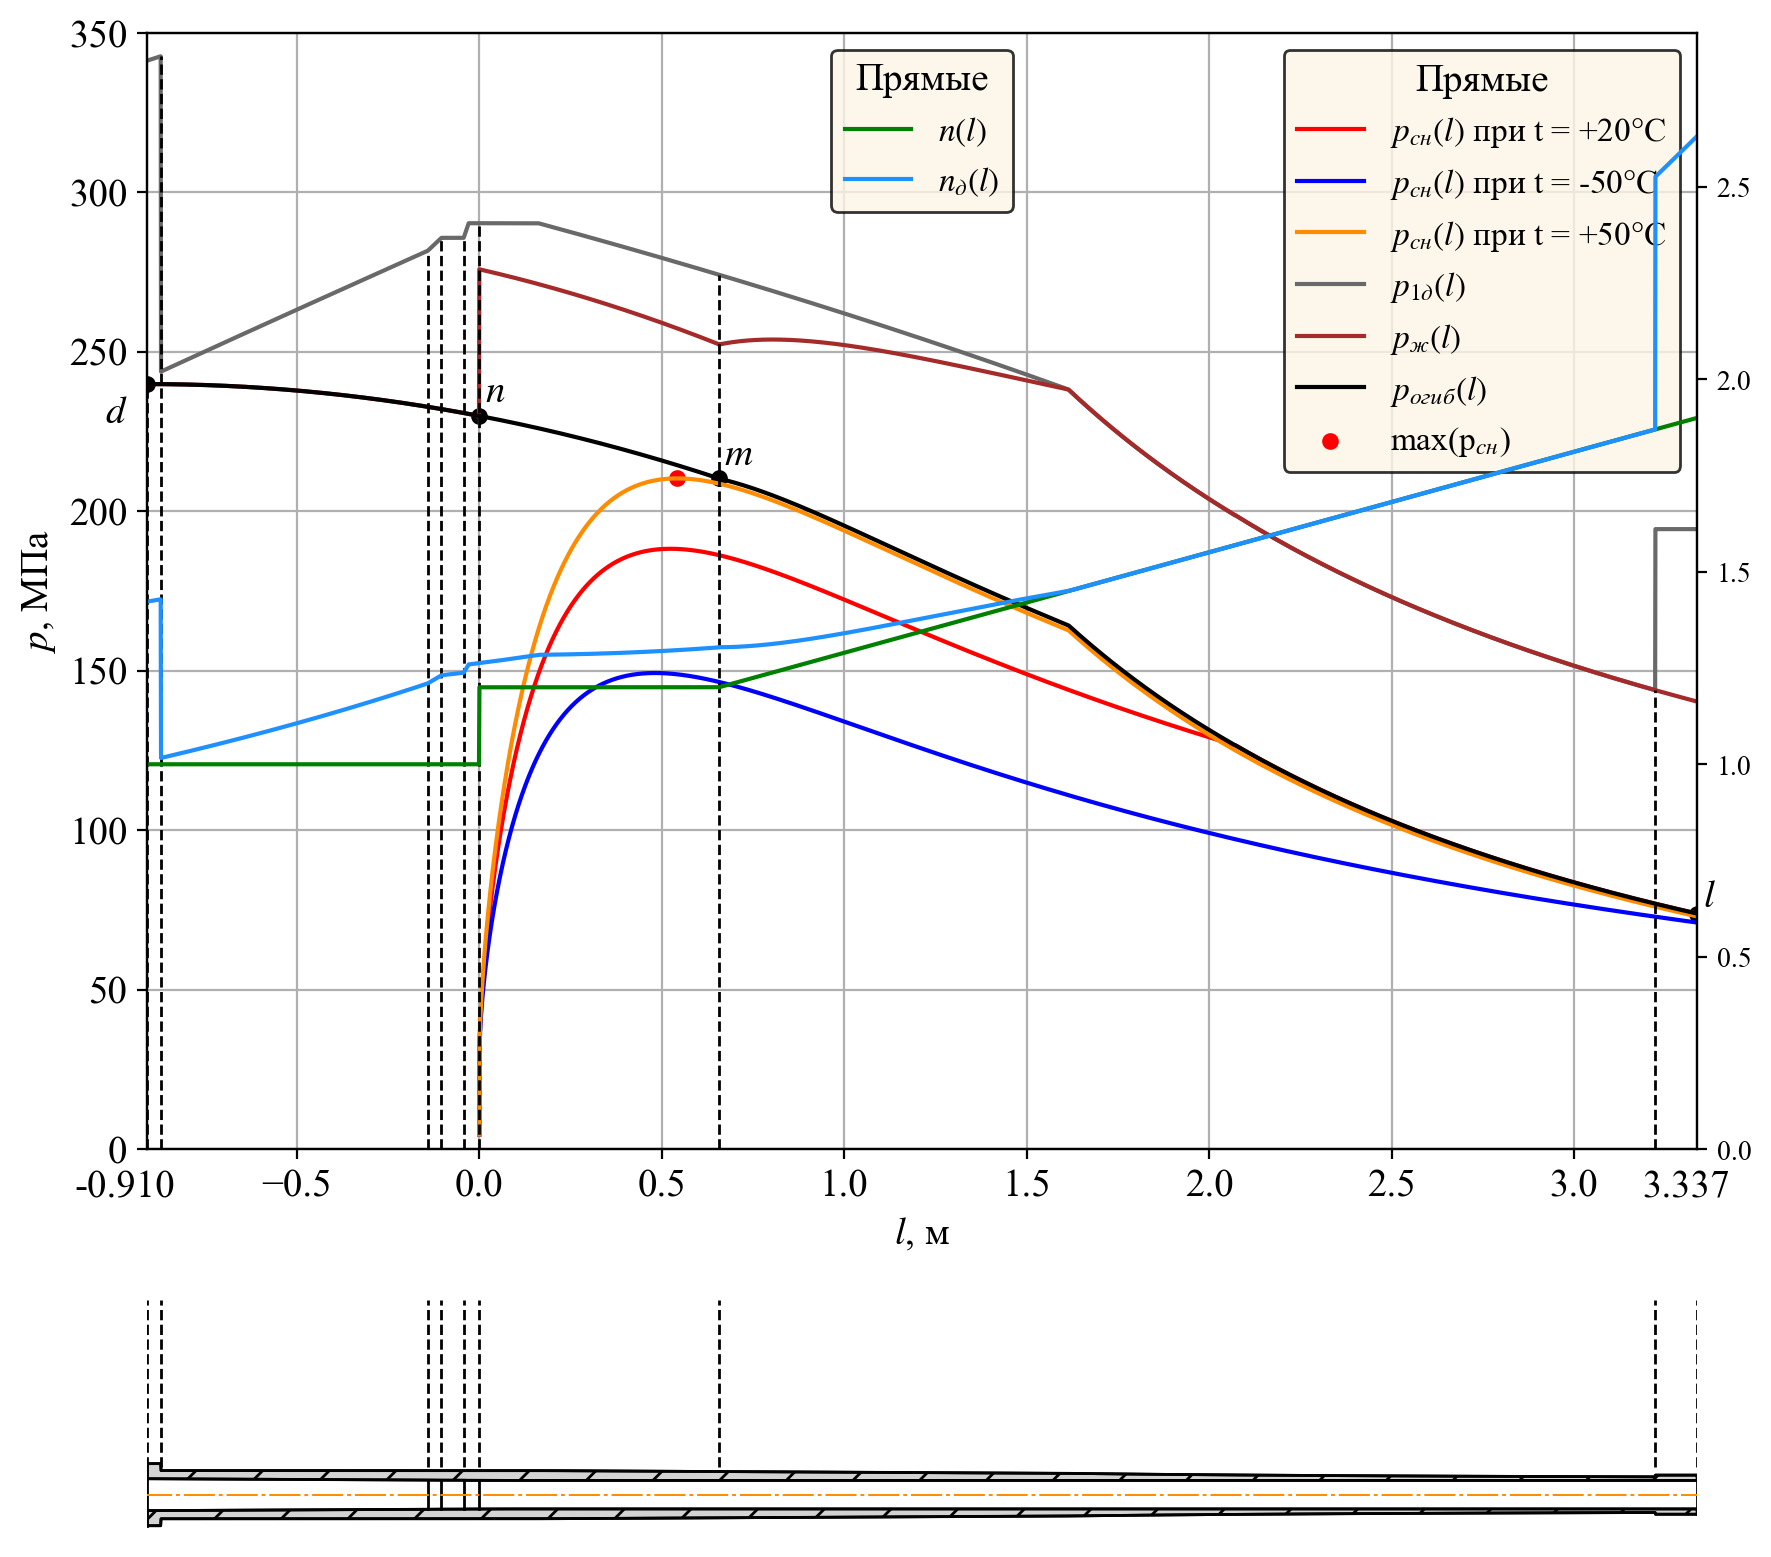

In [32]:
fig = plt.figure(figsize = (10, 10), dpi = 200)

gs = fig.add_gridspec(4, 1)
ax_1 = fig.add_subplot(gs[:3, :])
ax_2 = fig.add_subplot(5, 1, 5)

ax_2.set_frame_on(False)
ax_2.set_xticks([])
ax_2.set_yticks([])

ax_2.set_xlim(mass_l[0], mass_l[-1])
ax_1.set_xlim(mass_l[0], mass_l[-1])
ax_1.set_ylim(0, 350)

### ax1 - фигура для графиков
par1 = ax_1.twinx()
nlim = (0, mass_n.max() + 1)
par1.set_ylim(*nlim)

linewidth_graf1 = 1.5 # толщина для графиков
linewidth_graf2 = 1   # толщина для линий, идущих к точкам

p2,  = par1.plot(mass_l, mass_n,  color='green',      label='$n(l)$',       linestyle = 'solid', linewidth = linewidth_graf1)
p21, = par1.plot(mass_l, mass_nd, color='dodgerblue', label='$n_{д}(l)$', linestyle = 'solid', linewidth = linewidth_graf1)

linek0 = matplotlib.lines.Line2D ([xm, xm], [0, mass_p1d[mass_l < xm][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek1 = matplotlib.lines.Line2D ([mass_l_dm[0] + L_fl, mass_l_dm[0] + L_fl], [0, mass_p1d[mass_l < mass_l_dm[0] + L_fl][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek2 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок, mass_l_dm[0] + l_ок], [0, mass_p1d[mass_l < mass_l_dm[0] + l_ок][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek3 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок + l_пк, mass_l_dm[0] + l_ок + l_пк], [0, mass_p1d[mass_l < mass_l_dm[0] + l_ок + l_пк][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek4 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок + l_пк + l_ц, mass_l_dm[0] + l_ок + l_пк + l_ц], [0, mass_p1d[mass_l < mass_l_dm[0] + l_ок + l_пк + l_ц][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek5 = matplotlib.lines.Line2D ([0, 0], [0, mass_p1d[mass_l < 0][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek6 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [0, mass_p_ogib_dm.max()], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek7 = matplotlib.lines.Line2D ([mass_l[-1] - 1.5*d, mass_l[-1] - 1.5*d], [0,  mass_p1d[mass_l < mass_l[-1] - 1.5*d][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek8 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [0, mass_p_ogib_ml[-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")

ax_1.scatter(lpсн_max, pсн_max,                    color = 'red',   s = 25, label = 'max(p$_{сн}$)')
ax_1.scatter(mass_l_dm[0], mass_p_ogib_dm.max(),   color = 'black', s = 25)
ax_1.scatter(0, mass_p_ogib_dm[mass_l_dm < 0][-1], color = 'black', s = 25)
ax_1.scatter(mass_l_ml[-1], mass_p_ogib_ml[-1],    color = 'black', s = 25)
ax_1.scatter(xm, pсн_max,                          color = 'black', s = 25)

ax_1.plot(arr_xp1, pсн1,             label='$p_{сн}(l)$ при t = +20°C', color = 'red',        linewidth = linewidth_graf1)
ax_1.plot(arr_xp2, pсн2,             label='$p_{сн}(l)$ при t = -50°C', color = 'blue',       linewidth = linewidth_graf1)
ax_1.plot(arr_xp3, pсн3,             label='$p_{сн}(l)$ при t = +50°C', color = 'darkorange', linewidth = linewidth_graf1)
ax_1.plot(mass_l, mass_p1d,          label='$p_{1д}(l)$',               color='dimgrey',      linewidth = linewidth_graf1)
ax_1.plot(mass_l, mass_p_ж,          label='$p_ж(l)$',                  color='brown',        linewidth = linewidth_graf1)
ax_1.plot(mass_l_dm, mass_p_ogib_dm, label='$p_{огиб}(l)$',             color = 'black',      linewidth = linewidth_graf1)
ax_1.plot(mass_l_ml, mass_p_ogib_ml,                                    color = 'black',      linewidth = linewidth_graf1)

ax_1.text(mass_l_dm[0] - 1.5*d, 0.95 * mass_p_ogib_dm.max(), '$d$',    fontsize=14, color='black')
ax_1.text(d/5, 1.02 * mass_p_ogib_dm[mass_l_dm < 0][-1],     '$n$',    fontsize=14, color='black')
ax_1.text(xm + d/5, 1.02 * pсн3_max,                         '$m$',    fontsize=14, color='black')
ax_1.text(mass_l_ml[-1] + d/5, 1.03 * mass_p_ogib_ml[-1],    '$l$',    fontsize=14, color='black')
ax_1.text(mass_l[0] - 0.2, -15,                              '-0.910', fontsize=14, color='black')
ax_1.text(mass_l[-1] - 0.15, -15,                            '3.337',  fontsize=14, color='black')

ax_1.add_line(linek0)
ax_1.add_line(linek1)
ax_1.add_line(linek2)
ax_1.add_line(linek3)
ax_1.add_line(linek4)
ax_1.add_line(linek5)
ax_1.add_line(linek6)
ax_1.add_line(linek7)
ax_1.add_line(linek8)

ax_1.grid()

ax_1.set_xlabel("$l$, м",   fontsize = 14)
ax_1.set_ylabel("$p$, МПа", fontsize = 14)
ax_1.tick_params(labelsize=14)

### аx2 - фигура для эскиза ствола
ax_2.set_aspect('equal')

ax_2.plot(mass_l, mass_r2_constr, color="black", linewidth = 1)
ax_2.plot(mass_l, mass_r1,        color="black", linewidth = 1)

ax_2.plot(mass_l, -mass_r2_constr, color="black", linewidth = 1)
ax_2.plot(mass_l, -mass_r1,        color="black", linewidth = 1)

line_os = matplotlib.lines.Line2D ([mass_l[0] - d/5, mass_l[-1] + d/5], [0, 0], linewidth = 0.7, dashes=[16,2,2,2], color="darkorange")
linewidth1 = 1
line1 = matplotlib.lines.Line2D ([mass_l[0], mass_l[0]], [-mass_r2_constr[0], mass_r2_constr[0]],                           linewidth = linewidth1, linestyle = 'solid', color="black")
line2 = matplotlib.lines.Line2D ([l_ок + mass_l[0], l_ок + mass_l[0]], [-d2/2, d2/2],                                       linewidth = linewidth1, linestyle = 'solid', color="black")
line3 = matplotlib.lines.Line2D ([l_ок + l_пк + mass_l[0], l_ок + l_пк + mass_l[0]], [-d1/2, d1/2],                         linewidth = linewidth1, linestyle = 'solid', color="black")
line4 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + mass_l[0], l_ок + l_пк + l_ц + mass_l[0]], [-d1/2, d1/2],             linewidth = linewidth1, linestyle = 'solid', color="black")
line5 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв + mass_l[0], l_ок + l_пк + l_ц + l_кв + mass_l[0]], [-d/2, d/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line6 = matplotlib.lines.Line2D ([mass_l[-1], mass_l[-1]], [-mass_r2_constr[-1], mass_r2_constr[-1]],                       linewidth = linewidth1, linestyle = 'solid', color="black")

linek00 = matplotlib.lines.Line2D ([xm, xm], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek11 = matplotlib.lines.Line2D ([mass_l_dm[0] + L_fl, mass_l_dm[0] + L_fl], [d, d*7], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek22 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок, mass_l_dm[0] + l_ок], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek33 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок + l_пк, mass_l_dm[0] + l_ок + l_пк], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek44 = matplotlib.lines.Line2D ([mass_l_dm[0] + l_ок + l_пк + l_ц, mass_l_dm[0] + l_ок + l_пк + l_ц], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek55 = matplotlib.lines.Line2D ([0, 0], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek66 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek77 = matplotlib.lines.Line2D ([mass_l[-1] - 1.5*d, mass_l[-1] - 1.5*d], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek88 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [d, 7*d], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")

ax_2.add_line(line1)
ax_2.add_line(line2)
ax_2.add_line(line3)
ax_2.add_line(line4)
ax_2.add_line(line5)
ax_2.add_line(line6)
ax_2.add_line(line_os)
ax_2.add_line(linek00)
ax_2.add_line(linek11)
ax_2.add_line(linek22)
ax_2.add_line(linek33)
ax_2.add_line(linek44)
ax_2.add_line(linek55)
ax_2.add_line(linek66)
ax_2.add_line(linek77)
ax_2.add_line(linek88)

ax_2.fill_between(mass_l, mass_r2_constr, mass_r1,   facecolor="lightgrey", hatch="/", edgecolor="black", linewidth=linewidth1)
ax_2.fill_between(mass_l, -mass_r2_constr, -mass_r1, facecolor="lightgrey", hatch="/", edgecolor="black", linewidth=linewidth1)

ax_1.legend(
    fontsize = 12,
    ncol = 1,
    facecolor = 'oldlace',
    loc='upper right',
    edgecolor = 'k',
    title = 'Прямые',
    title_fontsize = '14')
par1.legend(
    fontsize = 12,
    ncol = 1,
    facecolor = 'oldlace',
    loc='upper center',
    edgecolor = 'k',
    title = 'Прямые',
    title_fontsize = '14')

plt.savefig('итоговый график.png', dpi=600, bbox_inches='tight')
plt.show()

### 2. График с кривой желаемого давления

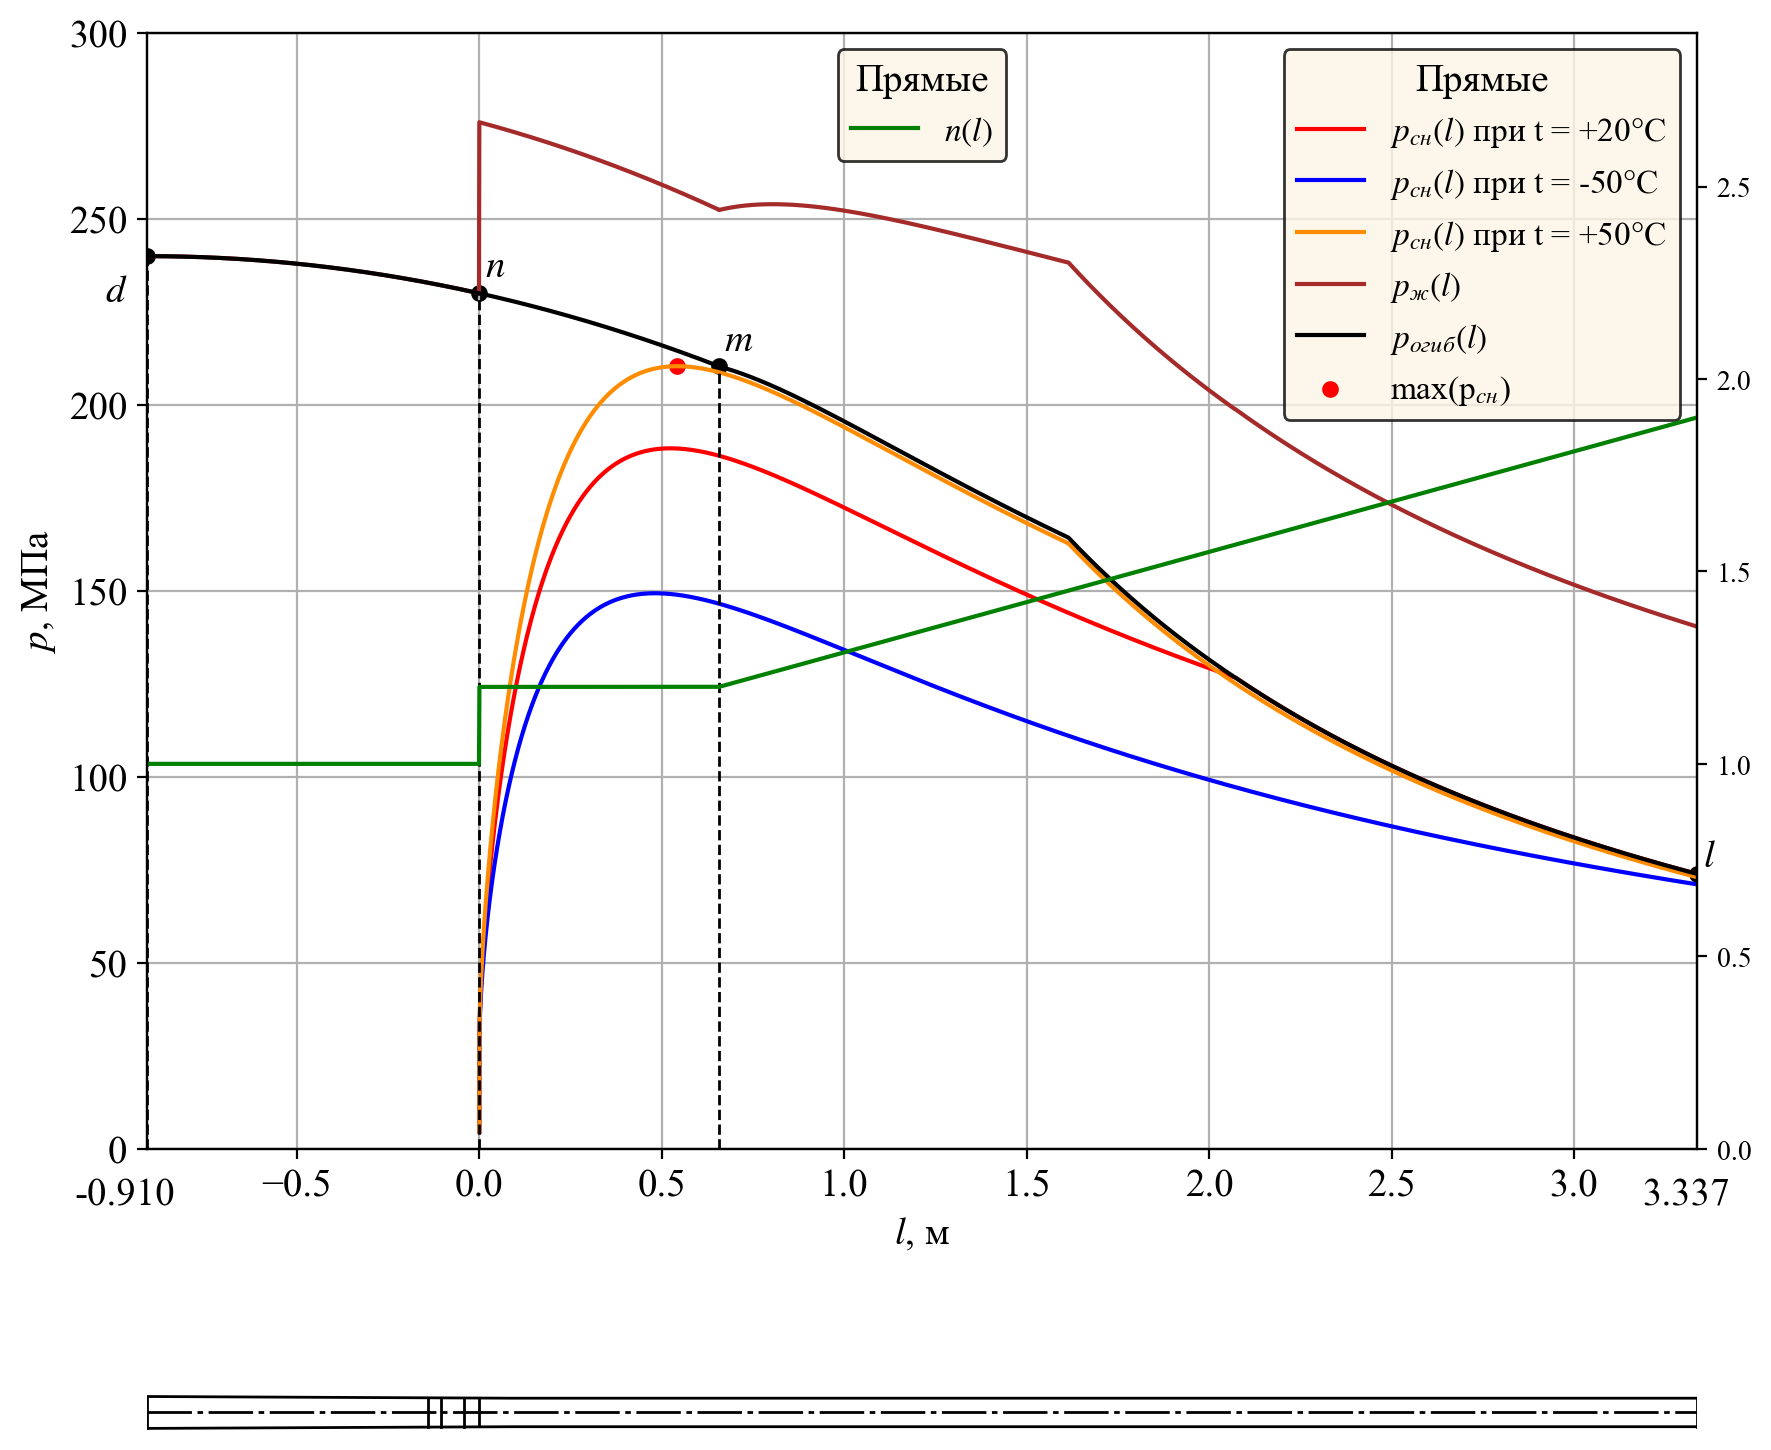

In [33]:
fig = plt.figure(figsize = (10, 10), dpi = 200)

gs = fig.add_gridspec(4, 1)
ax_1 = fig.add_subplot(gs[:3, :])
ax_2 = fig.add_subplot(5, 1, 5)

ax_2.set_frame_on(False)
ax_2.set_xticks([])
ax_2.set_yticks([])

ax_2.set_xlim(mass_l[0], mass_l[-1])
ax_1.set_xlim(mass_l[0], mass_l[-1])
ax_1.set_ylim(0, 300)

### ax1 - фигура для графиков
par1 = ax_1.twinx()
nlim = (0, mass_n.max() + 1)
par1.set_ylim(*nlim)

linewidth_graf1 = 1.5 # толщина для графиков
linewidth_graf2 = 1   # толщина для линий, идущих к точкам

p2,  = par1.plot(mass_l, mass_n,  color='green',      label='$n(l)$',       linestyle = 'solid', linewidth = linewidth_graf1)

linek0 = matplotlib.lines.Line2D ([xm, xm], [0, mass_p_ogib_dm[mass_l_dm < xm][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek1 = matplotlib.lines.Line2D ([0, 0], [0, mass_p_ogib_dm[mass_l_dm < 0][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek2 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [0, mass_p_ogib_dm.max()], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek3 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [0, mass_p_ogib_ml[-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")

ax_1.scatter(lpсн_max, pсн_max,                    color = 'red',   s = 25, label = 'max(p$_{сн}$)')
ax_1.scatter(mass_l_dm[0], mass_p_ogib_dm.max(),   color = 'black', s = 25)
ax_1.scatter(0, mass_p_ogib_dm[mass_l_dm < 0][-1], color = 'black', s = 25)
ax_1.scatter(mass_l_ml[-1], mass_p_ogib_ml[-1],    color = 'black', s = 25)
ax_1.scatter(xm, pсн_max,                          color = 'black', s = 25)

ax_1.plot(arr_xp1, pсн1,             label='$p_{сн}(l)$ при t = +20°C', color = 'red',        linewidth = linewidth_graf1)
ax_1.plot(arr_xp2, pсн2,             label='$p_{сн}(l)$ при t = -50°C', color = 'blue',       linewidth = linewidth_graf1)
ax_1.plot(arr_xp3, pсн3,             label='$p_{сн}(l)$ при t = +50°C', color = 'darkorange', linewidth = linewidth_graf1)
ax_1.plot(mass_l, mass_p_ж,          label='$p_ж(l)$',                  color='brown',        linewidth = linewidth_graf1)
ax_1.plot(mass_l_dm, mass_p_ogib_dm, label='$p_{огиб}(l)$',             color = 'black',      linewidth = linewidth_graf1)
ax_1.plot(mass_l_ml, mass_p_ogib_ml,                                    color = 'black',      linewidth = linewidth_graf1)

ax_1.text(mass_l_dm[0] - 1.5*d, 0.95 * mass_p_ogib_dm.max(), '$d$',    fontsize=14, color='black')
ax_1.text(d/5, 1.02 * mass_p_ogib_dm[mass_l_dm < 0][-1],     '$n$',    fontsize=14, color='black')
ax_1.text(xm + d/5, 1.02 * pсн3_max,                         '$m$',    fontsize=14, color='black')
ax_1.text(mass_l_ml[-1] + d/5, 1.03 * mass_p_ogib_ml[-1],    '$l$',    fontsize=14, color='black')
ax_1.text(mass_l[0] - 0.2, -15,                              '-0.910', fontsize=14, color='black')
ax_1.text(mass_l[-1] - 0.15, -15,                            '3.337',  fontsize=14, color='black')

ax_1.add_line(linek0)
ax_1.add_line(linek1)
ax_1.add_line(linek2)
ax_1.add_line(linek3)

ax_1.grid()

ax_1.set_xlabel("$l$, м",   fontsize = 14)
ax_1.set_ylabel("$p$, МПа", fontsize = 14)
ax_1.tick_params(labelsize=14)

### аx2 - фигура для эскиза ствола
ax_2.set_aspect('equal')

linewidth1 = 1

line_os = matplotlib.lines.Line2D ([mass_l[0], mass_l[-1]], [0, 0], linewidth = 1, dashes=[16,2,2,2], color="black")
line1 = matplotlib.lines.Line2D ([mass_l[0], mass_l[0]], [-mass_r1[0], mass_r1[0]], linewidth = linewidth1, linestyle = 'solid', color="black")
line2 = matplotlib.lines.Line2D ([l_ок + mass_l[0], l_ок + mass_l[0]], [-d2/2, d2/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line3 = matplotlib.lines.Line2D ([l_ок + l_пк + mass_l[0], l_ок + l_пк + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line4 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + mass_l[0], l_ок + l_пк + l_ц + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line5 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв + mass_l[0], l_ок + l_пк + l_ц + l_кв + mass_l[0]], [-d/2, d/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line6 = matplotlib.lines.Line2D ([mass_l[-1], mass_l[-1]], [-mass_r1[-1], mass_r1[-1]], linewidth = linewidth1, linestyle = 'solid', color="black")

ax_2.plot(mass_l, -mass_r1, color = 'black', linewidth = linewidth1)
ax_2.plot(mass_l, mass_r1, color = 'black', linewidth = linewidth1)

ax_2.add_line(line_os)
ax_2.add_line(line1)
ax_2.add_line(line2)
ax_2.add_line(line3)
ax_2.add_line(line4)
ax_2.add_line(line5)
ax_2.add_line(line6)

ax_1.legend(
    fontsize = 12,
    ncol = 1,
    facecolor = 'oldlace',
    loc='upper right',
    edgecolor = 'k',
    title = 'Прямые',
    title_fontsize = '14')
par1.legend(
    fontsize = 12,
    ncol = 1,
    facecolor = 'oldlace',
    loc='upper center',
    edgecolor = 'k',
    title = 'Прямые',
    title_fontsize = '14')

plt.savefig('кривая желаемого давления.png', dpi=600, bbox_inches='tight')
plt.show()

### 3. График с кривой огибающей давление

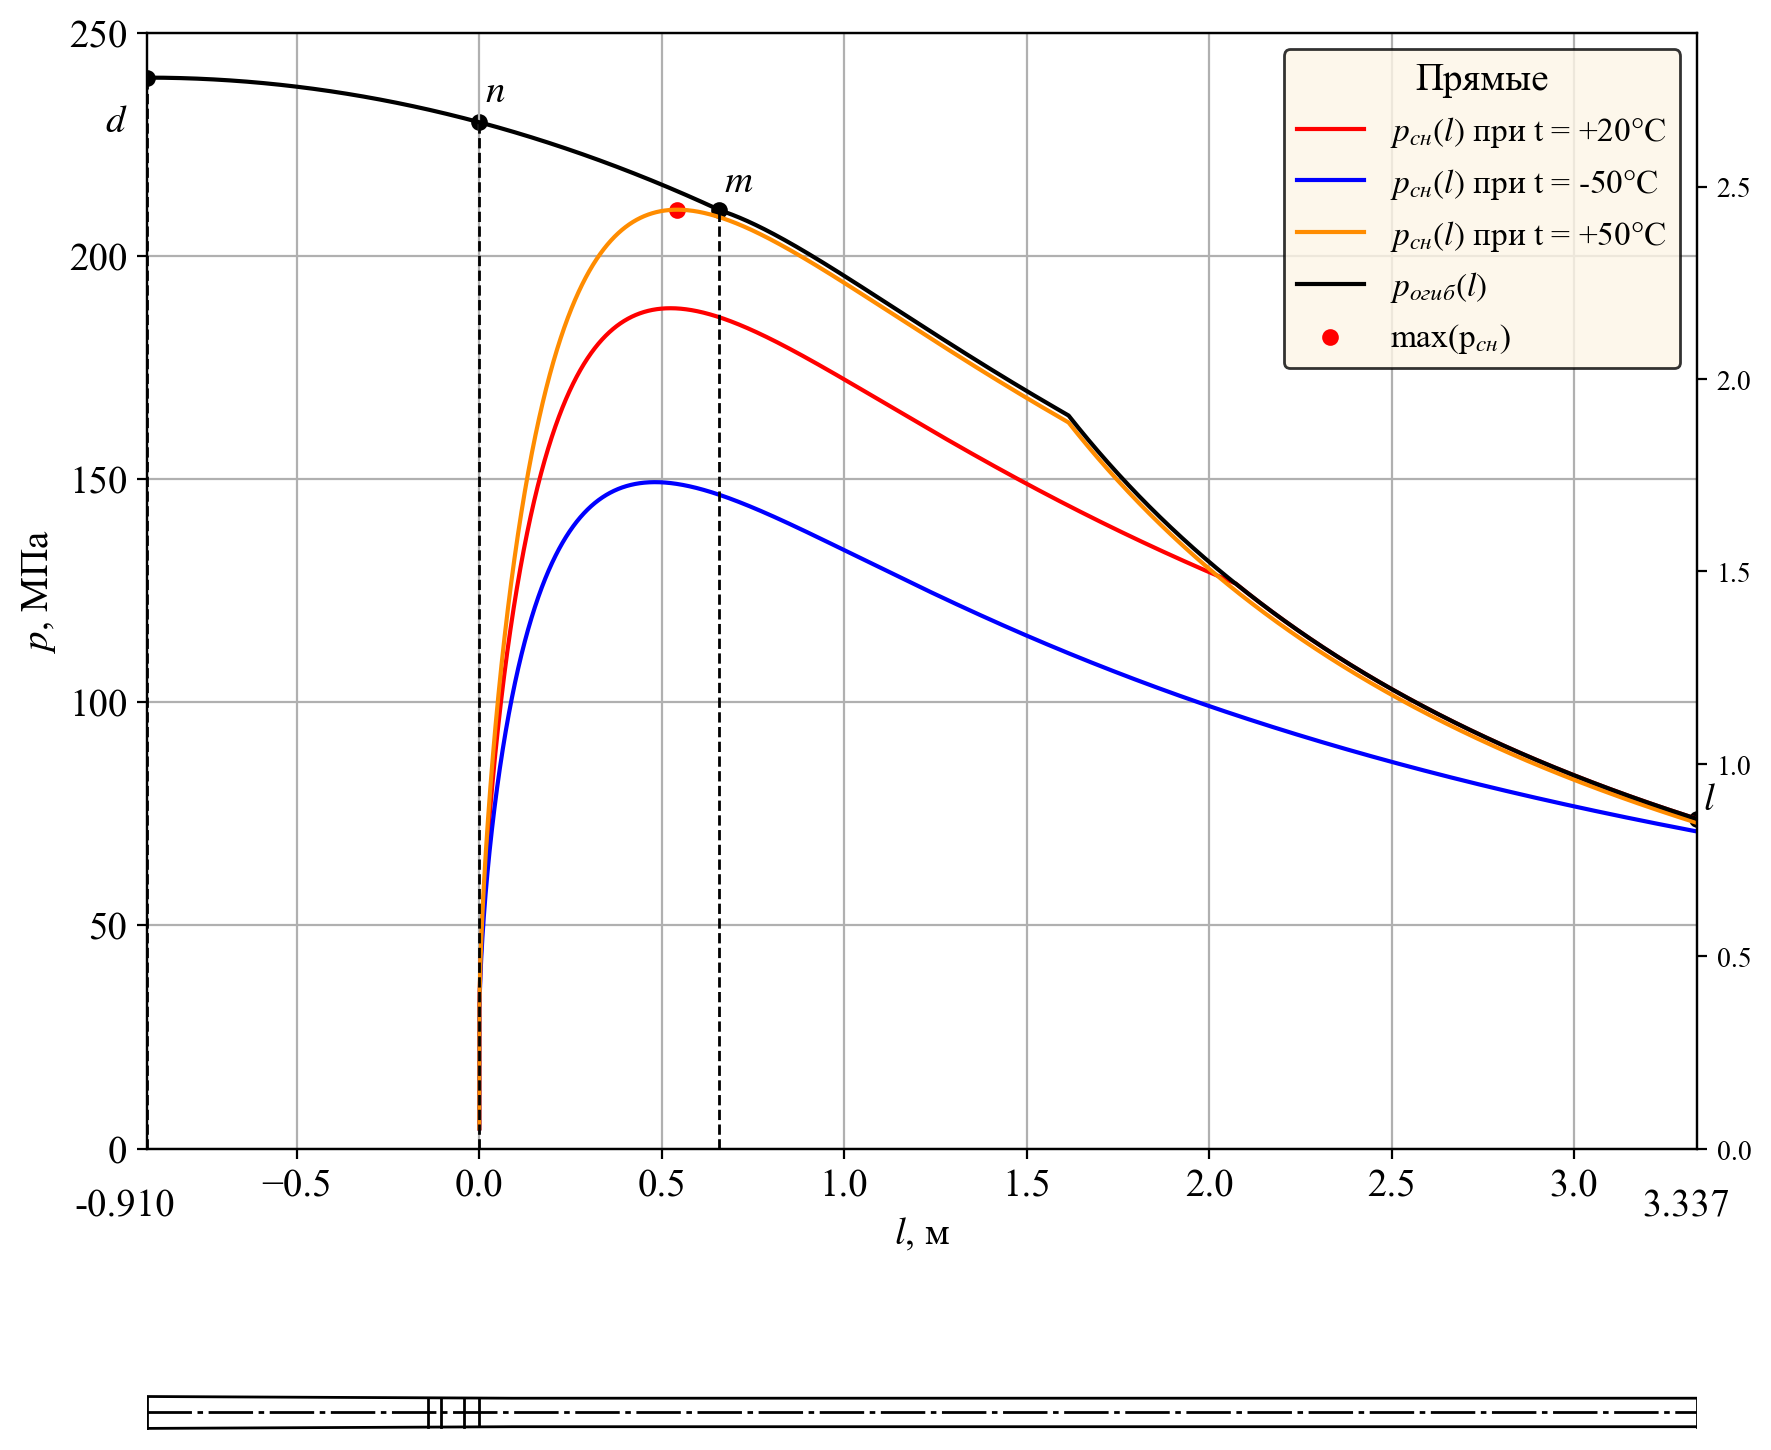

In [34]:
fig = plt.figure(figsize = (10, 10), dpi = 200)

gs = fig.add_gridspec(4, 1)
ax_1 = fig.add_subplot(gs[:3, :])
ax_2 = fig.add_subplot(5, 1, 5)

ax_2.set_frame_on(False)
ax_2.set_xticks([])
ax_2.set_yticks([])

ax_2.set_xlim(mass_l[0], mass_l[-1])
ax_1.set_xlim(mass_l[0], mass_l[-1])
ax_1.set_ylim(0, 250)

### ax1 - фигура для графиков
par1 = ax_1.twinx()
nlim = (0, mass_n.max() + 1)
par1.set_ylim(*nlim)

linewidth_graf1 = 1.5 # толщина для графиков
linewidth_graf2 = 1   # толщина для линий, идущих к точкам

linek0 = matplotlib.lines.Line2D ([xm, xm], [0, mass_p_ogib_dm[mass_l_dm < xm][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek1 = matplotlib.lines.Line2D ([0, 0], [0, mass_p_ogib_dm[mass_l_dm < 0][-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek2 = matplotlib.lines.Line2D ([mass_l_dm[0], mass_l_dm[0]], [0, mass_p_ogib_dm.max()], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")
linek3 = matplotlib.lines.Line2D ([mass_l_ml[-1], mass_l_ml[-1]], [0, mass_p_ogib_ml[-1]], linewidth = linewidth_graf2, linestyle = 'dashed', color="black")

ax_1.scatter(lpсн_max, pсн_max,                    color = 'red',   s = 25, label = 'max(p$_{сн}$)')
ax_1.scatter(mass_l_dm[0], mass_p_ogib_dm.max(),   color = 'black', s = 25)
ax_1.scatter(0, mass_p_ogib_dm[mass_l_dm < 0][-1], color = 'black', s = 25)
ax_1.scatter(mass_l_ml[-1], mass_p_ogib_ml[-1],    color = 'black', s = 25)
ax_1.scatter(xm, pсн_max,                          color = 'black', s = 25)

ax_1.plot(arr_xp1, pсн1,             label='$p_{сн}(l)$ при t = +20°C', color = 'red',        linewidth = linewidth_graf1)
ax_1.plot(arr_xp2, pсн2,             label='$p_{сн}(l)$ при t = -50°C', color = 'blue',       linewidth = linewidth_graf1)
ax_1.plot(arr_xp3, pсн3,             label='$p_{сн}(l)$ при t = +50°C', color = 'darkorange', linewidth = linewidth_graf1)
ax_1.plot(mass_l_dm, mass_p_ogib_dm, label='$p_{огиб}(l)$',             color = 'black',      linewidth = linewidth_graf1)
ax_1.plot(mass_l_ml, mass_p_ogib_ml,                                    color = 'black',      linewidth = linewidth_graf1)

ax_1.text(mass_l_dm[0] - 1.5*d, 0.95 * mass_p_ogib_dm.max(), '$d$',    fontsize=14, color='black')
ax_1.text(d/5, 1.02 * mass_p_ogib_dm[mass_l_dm < 0][-1],     '$n$',    fontsize=14, color='black')
ax_1.text(xm + d/5, 1.02 * pсн3_max,                         '$m$',    fontsize=14, color='black')
ax_1.text(mass_l_ml[-1] + d/5, 1.03 * mass_p_ogib_ml[-1],    '$l$',    fontsize=14, color='black')
ax_1.text(mass_l[0] - 0.2, -15,                              '-0.910', fontsize=14, color='black')
ax_1.text(mass_l[-1] - 0.15, -15,                            '3.337',  fontsize=14, color='black')

ax_1.add_line(linek0)
ax_1.add_line(linek1)
ax_1.add_line(linek2)
ax_1.add_line(linek3)

ax_1.grid()

ax_1.set_xlabel("$l$, м",   fontsize = 14)
ax_1.set_ylabel("$p$, МПа", fontsize = 14)
ax_1.tick_params(labelsize=14)

### аx2 - фигура для эскиза ствола
ax_2.set_aspect('equal')

linewidth1 = 1

line_os = matplotlib.lines.Line2D ([mass_l[0], mass_l[-1]], [0, 0], linewidth = 1, dashes=[16,2,2,2], color="black")
line1 = matplotlib.lines.Line2D ([mass_l[0], mass_l[0]], [-mass_r1[0], mass_r1[0]], linewidth = linewidth1, linestyle = 'solid', color="black")
line2 = matplotlib.lines.Line2D ([l_ок + mass_l[0], l_ок + mass_l[0]], [-d2/2, d2/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line3 = matplotlib.lines.Line2D ([l_ок + l_пк + mass_l[0], l_ок + l_пк + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line4 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + mass_l[0], l_ок + l_пк + l_ц + mass_l[0]], [-d1/2, d1/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line5 = matplotlib.lines.Line2D ([l_ок + l_пк + l_ц + l_кв + mass_l[0], l_ок + l_пк + l_ц + l_кв + mass_l[0]], [-d/2, d/2], linewidth = linewidth1, linestyle = 'solid', color="black")
line6 = matplotlib.lines.Line2D ([mass_l[-1], mass_l[-1]], [-mass_r1[-1], mass_r1[-1]], linewidth = linewidth1, linestyle = 'solid', color="black")

ax_2.plot(mass_l, -mass_r1, color = 'black', linewidth = linewidth1)
ax_2.plot(mass_l, mass_r1, color = 'black', linewidth = linewidth1)

ax_2.add_line(line_os)
ax_2.add_line(line1)
ax_2.add_line(line2)
ax_2.add_line(line3)
ax_2.add_line(line4)
ax_2.add_line(line5)
ax_2.add_line(line6)

ax_1.legend(
    fontsize = 12,
    ncol = 1,
    facecolor = 'oldlace',
    loc='upper right',
    edgecolor = 'k',
    title = 'Прямые',
    title_fontsize = '14')

plt.savefig('кривая огибающего давления.png', dpi=600, bbox_inches='tight')
plt.show()